In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import AutoARIMA, ARIMA
from darts.metrics.metrics import mae, mse
from darts.dataprocessing.transformers import Scaler
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models.original_models
import models.models_3d_atomics_on_variate_to_concepts
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [2]:
series = ETTh1Dataset().load()


In [3]:
train_series, test_series = series.split_before(0.6)
val_series, test_series = test_series.split_before(0.5)


In [4]:
scaler = StandardScaler()
scaler_wrapper = Scaler(scaler)
train_series = scaler_wrapper.fit_transform(train_series)
val_series = scaler_wrapper.transform(val_series)
test_series = scaler_wrapper.transform(test_series)


In [5]:
def preprocess_data():
    series = ETTh1Dataset().load()
    scaler = StandardScaler()
    
    train_series, test_series = series.split_before(0.6)
    val_series, test_series = test_series.split_before(0.5)
    
    scaler_wrapper = Scaler(scaler)
    train_series = scaler_wrapper.fit_transform(train_series)
    val_series = scaler_wrapper.transform(val_series)
    test_series = scaler_wrapper.transform(test_series)

    return train_series, val_series, test_series


In [6]:
batch_size = 32
learning_rate = 0.005
epochs = 10
seq_len = 336
pred_len = 96



Missing values :   component
HUFL    False
HULL    False
MUFL    False
MULL    False
LUFL    False
LULL    False
OT      False
dtype: bool


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

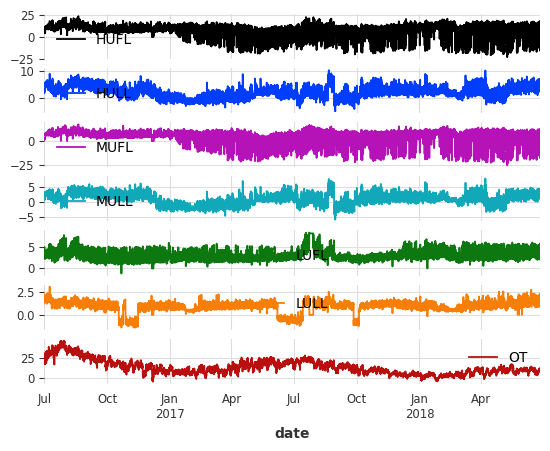

In [7]:
data = series.pd_dataframe()
print ("\nMissing values :  ", data.isnull().any())
data.plot(subplots=True)

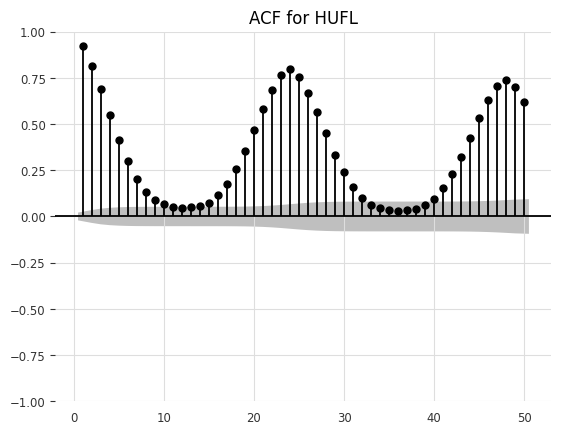

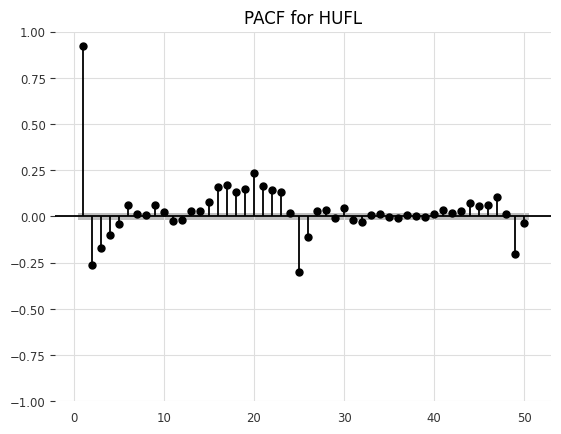

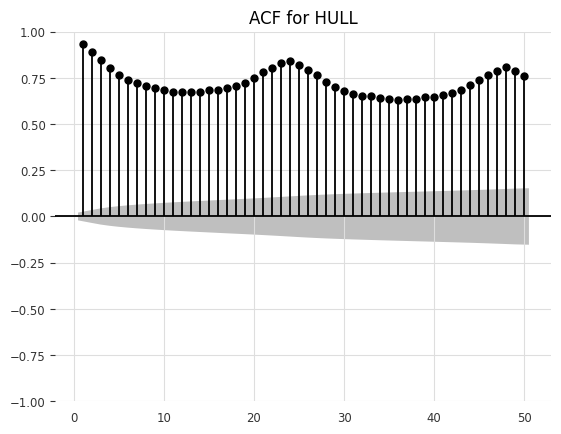

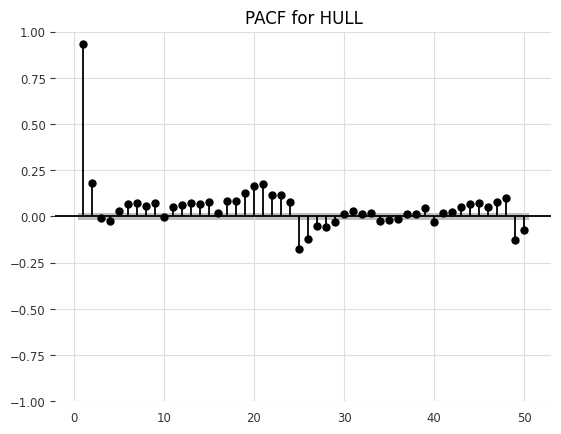

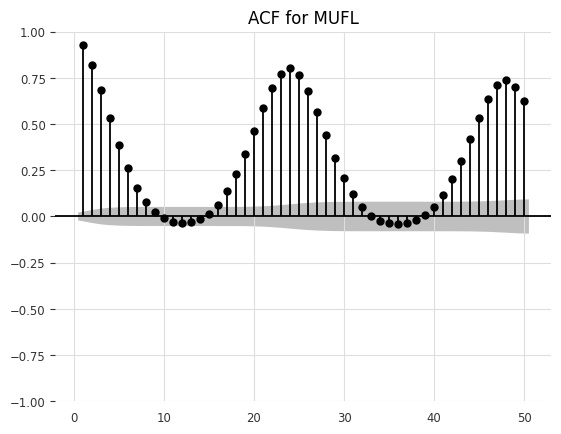

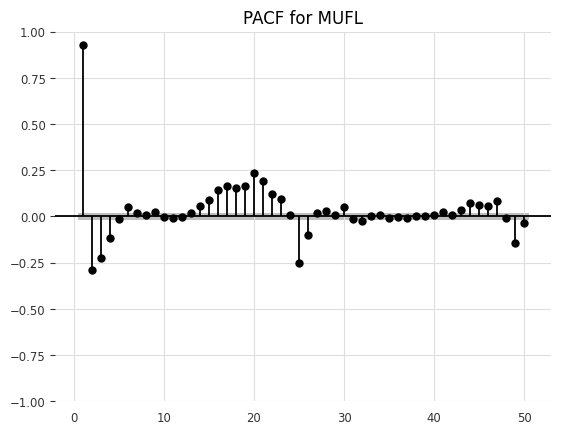

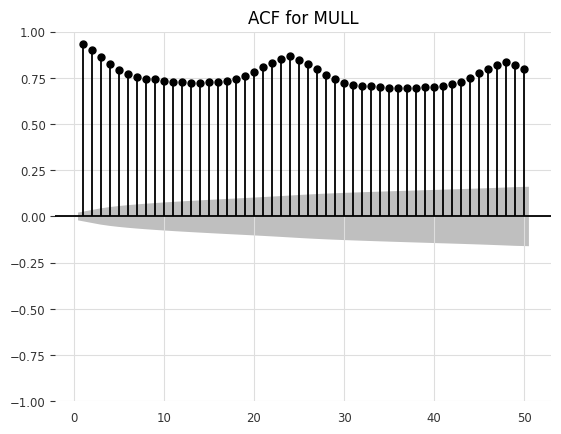

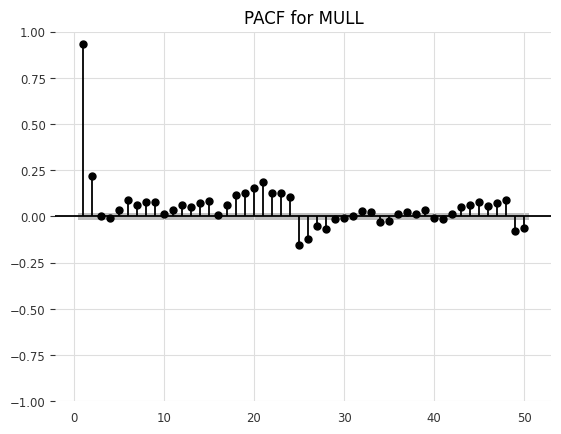

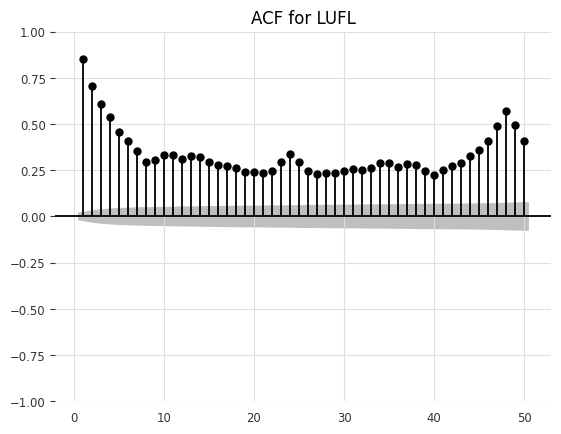

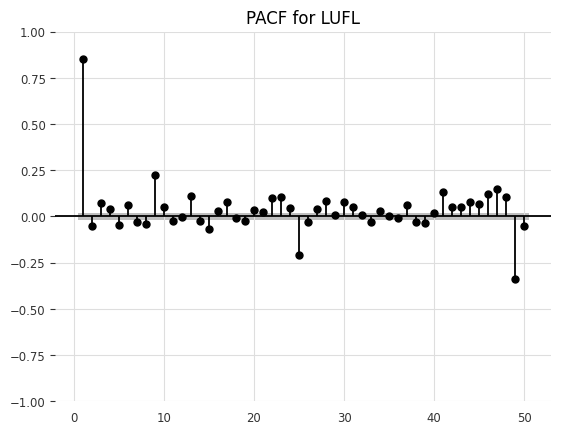

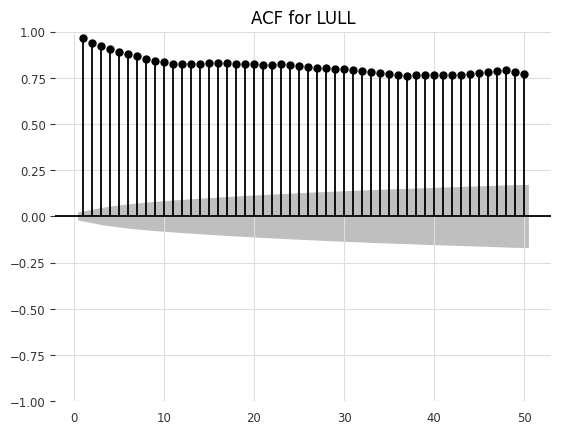

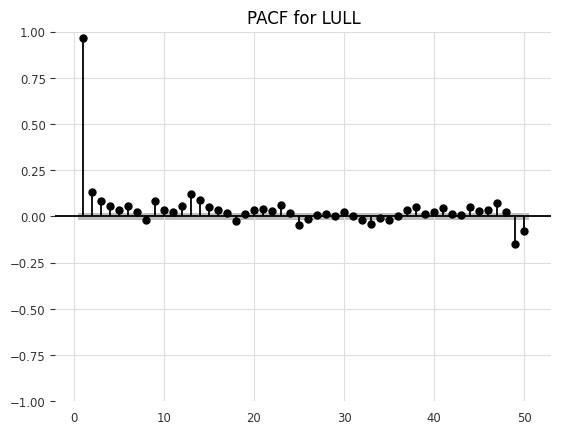

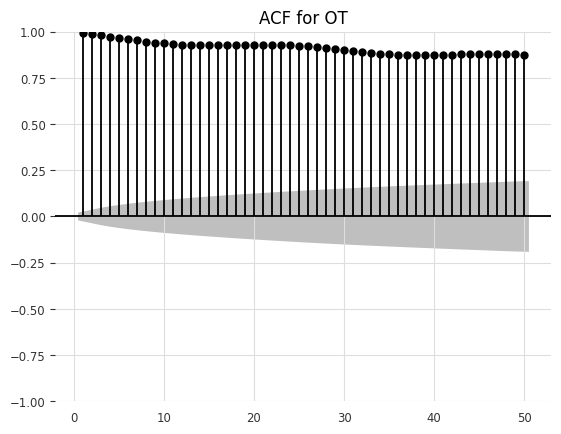

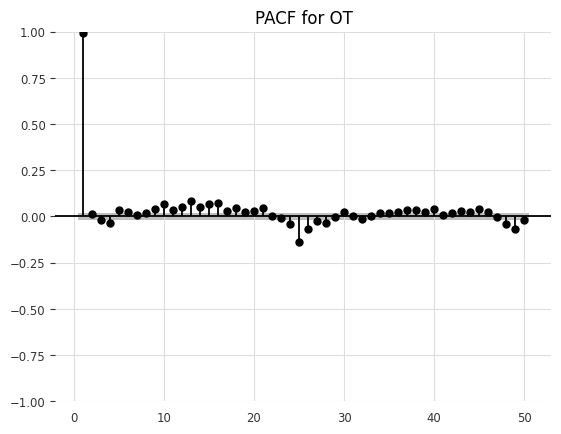

In [8]:
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

first, second = series.split_before(0.5)
data = first.pd_dataframe()

for col in data.columns:
    plot_acf(data[col], lags=50, alpha=0.05, zero=False)
    plt.title(f"ACF for {col}")
    plt.show()

    plot_pacf(data[col], lags=50, alpha=0.05, zero=False)
    plt.title(f"PACF for {col}")
    plt.show()


In [15]:
train_series, val_series, test_series = preprocess_data()

ohne_cov = AutoARIMA(start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5, 
                  start_P=0, D=None, start_Q=0, max_P=2, max_D=1, max_Q=2,
                  max_order=5, m=24, # hourly, so 24 
                  stepwise=True, maxiter=1,
                  error_action='ignore', suppress_warnings=True, trace=True)
# ohne_cov.fit(series=train_series["OT"])
# ohne_cov.model.summary()


In [9]:
train_series, val_series, test_series = preprocess_data()

mit_cov = AutoARIMA(start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5, 
                  start_P=0, D=None, start_Q=0, max_P=2, max_D=1, max_Q=2,
                  max_order=5, m=24, # hourly, so 24 
                  stepwise=True, maxiter=100,
                  error_action='ignore', suppress_warnings=True, trace=True)
mit_cov.fit(series=train_series["OT"], future_covariates=train_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]])
mit_cov.model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-14113.414, Time=2.66 sec


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-14383.061, Time=53.25 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-14338.690, Time=48.80 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-14115.395, Time=2.95 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=-14117.280, Time=5.07 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=-14482.356, Time=126.77 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=494.32 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=166.71 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=-14453.531, Time=137.16 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=-14482.669, Time=159.28 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=-14381.946, Time=61.82 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=569.19 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=207.76 sec
 ARIMA(3,1,0)(2,0,0)[24] intercept   : AIC=-14480.694, Time=167.75 sec
 ARIMA(2,1,1)(2,0,0)[24] intercept   : AIC=-14480.690, Time=173.54 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AI

: 

In [9]:
# ARIMA(0,1,1)(2,0,0)[24]
ohne_cov = ARIMA(p=0, d=1, q=1, seasonal_order=(2,0,0,24))

#  ARIMA(2,1,2)(2,0,0)[24] intercept
mit_cov = ARIMA(p=2, d=1, q=2, seasonal_order=(2,0,0,24))


In [12]:
maes = 0
mses = 0
steps = test_series.n_timesteps - seq_len - pred_len
print("steps", steps)

for i in range(steps):
    ohne_cov.fit(test_series["OT"][i:i+seq_len])
    pred = ohne_cov.predict(pred_len)
    maes += mae(test_series["OT"], pred["OT"], intersect=True)
    mses += mse(test_series["OT"], pred["OT"], intersect=True)

maes /= steps
print("MAE", maes)
mses /= steps
print("MSE", mses)

steps 3053


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

MAE 0.2929282834425806
MSE 0.15367504572954935


In [16]:
train_and_val_series = train_series.concatenate(val_series)
ohne_cov.fit(train_and_val_series["OT"])
pred = ohne_cov.predict(pred_len)

# Plot the predictions
test_series["OT"][:pred_len].plot(label='Test data')
pred.plot(label='Pred')
plt.title("Without future covariates")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-20904.175, Time=0.95 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-21263.939, Time=3.71 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-21191.335, Time=4.27 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-20906.130, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=-20905.231, Time=0.61 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=-21411.375, Time=17.19 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=-21637.597, Time=22.21 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=-21631.596, Time=5.41 sec
 ARIMA(1,1,0)(2,0,2)[24] intercept   : AIC=inf, Time=23.16 sec
 ARIMA(1,1,0)(1,0,2)[24] intercept   : AIC=-21617.070, Time=20.32 sec
 ARIMA(0,1,0)(2,0,1)[24] intercept   : AIC=-21619.412, Time=19.15 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=-21632.480, Time=28.81 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=-21636.149, Time=26.09 sec
 ARIMA(0,1,1)(2,0,1)[24] intercept   : AIC=-21637.882, Time=

: 

In [14]:
maes = 0
mses = 0
steps = test_series.n_timesteps - seq_len - pred_len
print("steps", steps)

for i in range(steps):
    mit_cov.fit(test_series["OT"][i:i+seq_len], future_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][i:i+seq_len+pred_len])
    pred = mit_cov.predict(pred_len, future_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][i:i+seq_len+pred_len])
    maes += mae(test_series["OT"], pred["OT"], intersect=True)
    mses += mse(test_series["OT"], pred["OT"], intersect=True)

maes /= steps
print("MAE", maes)
mses /= steps
print("MSE", mses)

steps 3053


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
mit_cov.fit(test_series["OT"][:seq_len], future_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][:seq_len+pred_len])
pred = mit_cov.predict(pred_len, future_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][:seq_len+pred_len])

# Plot the predictions
test_series["OT"][seq_len:seq_len+pred_len].plot(label='Test data')
pred.plot(label='Pred')
plt.title("Using future covariates")


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Using future covariates')

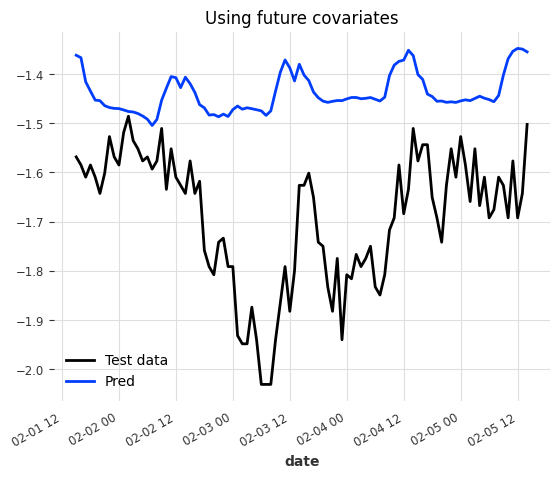

In [14]:
train_and_val_series = train_series.concatenate(val_series)
mit_cov.fit(train_and_val_series["OT"], future_covariates=train_and_val_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]])
pred = mit_cov.predict(pred_len, future_covariates=test_series[["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]][:pred_len])

# Plot the predictions
test_series["OT"][:pred_len].plot(label='Test data')
pred.plot(label='Pred')
plt.title("Using future covariates")
